In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import os
import xml.etree.ElementTree as ET
import tensorflow as tf
import cv2
from sklearn.model_selection import train_test_split
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

2026-01-09 20:02:42.055843: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1767988962.251762      23 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1767988962.307385      23 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1767988962.766134      23 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767988962.766171      23 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767988962.766174      23 computation_placer.cc:177] computation placer alr

/kaggle/input/pascal-voc-2012-dataset/VOC2012_train_val/VOC2012_train_val/devkit_doc.pdf
/kaggle/input/pascal-voc-2012-dataset/VOC2012_train_val/VOC2012_train_val/SegmentationObject/2010_002106.png
/kaggle/input/pascal-voc-2012-dataset/VOC2012_train_val/VOC2012_train_val/SegmentationObject/2007_004121.png
/kaggle/input/pascal-voc-2012-dataset/VOC2012_train_val/VOC2012_train_val/SegmentationObject/2009_003172.png
/kaggle/input/pascal-voc-2012-dataset/VOC2012_train_val/VOC2012_train_val/SegmentationObject/2007_005828.png
/kaggle/input/pascal-voc-2012-dataset/VOC2012_train_val/VOC2012_train_val/SegmentationObject/2011_000208.png
/kaggle/input/pascal-voc-2012-dataset/VOC2012_train_val/VOC2012_train_val/SegmentationObject/2010_000426.png
/kaggle/input/pascal-voc-2012-dataset/VOC2012_train_val/VOC2012_train_val/SegmentationObject/2011_001341.png
/kaggle/input/pascal-voc-2012-dataset/VOC2012_train_val/VOC2012_train_val/SegmentationObject/2009_002291.png
/kaggle/input/pascal-voc-2012-dataset/V

In [2]:
CLASSES = ["person", "car", "dog", "bicycle", "cat"]
NUM_CLASSES = len(CLASSES)
CLASS_TO_ID = {name: i for i, name in enumerate(CLASSES)}
def parse_voc_xml(xml_path):
    tree = ET.parse(xml_path)
    root = tree.getroot()

    boxes = []
    labels = []

    for obj in root.findall("object"):
        cls = obj.find("name").text
        if cls not in CLASS_TO_ID:
            continue

        bbox = obj.find("bndbox")
        xmin = int(float(bbox.find("xmin").text))
        ymin = int(float(bbox.find("ymin").text))
        xmax = int(float(bbox.find("xmax").text))
        ymax = int(float(bbox.find("ymax").text))

        boxes.append([xmin, ymin, xmax, ymax])
        labels.append(CLASS_TO_ID[cls])

    return np.array(boxes), np.array(labels)

In [3]:
def load_image_and_labels(img_path, xml_path):
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    boxes, labels = parse_voc_xml(xml_path)
    return image, boxes, labels
def normalize_boxes(boxes, img_w, img_h):
    boxes = boxes.astype(np.float32)
    if boxes.size == 0:
        return np.zeros((0, 4), dtype=np.float32)
    if boxes.ndim == 1:
        boxes = np.expand_dims(boxes, axis=0)
    boxes[:, [0, 2]] /= img_w
    boxes[:, [1, 3]] /= img_h
    return boxes

In [4]:
GRID_SIZE = 28
def encode_targets(boxes, labels):
    target = np.zeros((GRID_SIZE, GRID_SIZE, 5 + NUM_CLASSES))

    for box, label in zip(boxes, labels):
        x_center = (box[0] + box[2]) / 2
        y_center = (box[1] + box[3]) / 2
        w = box[2] - box[0]
        h = box[3] - box[1]

        grid_x = int(x_center * GRID_SIZE)
        grid_y = int(y_center * GRID_SIZE)

        if grid_x >= GRID_SIZE or grid_y >= GRID_SIZE:
            continue

        target[grid_y, grid_x, 0:4] = [x_center, y_center, w, h]
        target[grid_y, grid_x, 4] = 1.0
        target[grid_y, grid_x, 5 + label] = 1.0

    return target

In [5]:
def preprocess(img_path, xml_path):
    image, boxes, labels = load_image_and_labels(img_path, xml_path)
    h, w, _ = image.shape
    if boxes.size > 0:
        if np.random.rand() < 0.5:
            image = cv2.flip(image, 1)
            boxes[:, [0, 2]] = w - boxes[:, [2, 0]]

        if np.random.rand() < 0.5:
            image = image.astype(np.float32)
            brightness = np.random.uniform(-30, 30)
            image += brightness
            contrast = np.random.uniform(0.8, 1.2)
            image *= contrast
            image = np.clip(image, 0, 255)
            
    boxes = normalize_boxes(boxes, w, h)
    if boxes.size == 0:
      target = np.zeros((28, 28, 5 + NUM_CLASSES), dtype=np.float32)
    else: 
      target = encode_targets(boxes, labels)
    image = cv2.resize(image, (224, 224))
    image = image / 255.0
    return image.astype(np.float32), target.astype(np.float32)

In [6]:
IMAGE_DIR = "/kaggle/input/pascal-voc-2012-dataset/VOC2012_train_val/VOC2012_train_val/JPEGImages"
ANNOT_DIR = "/kaggle/input/pascal-voc-2012-dataset/VOC2012_train_val/VOC2012_train_val/Annotations"

image_files = sorted(os.listdir(IMAGE_DIR))
xml_files = sorted(os.listdir(ANNOT_DIR))

data_pairs = list(zip(
    [os.path.join(IMAGE_DIR, f) for f in image_files],
    [os.path.join(ANNOT_DIR, f.replace(".jpg", ".xml")) for f in image_files]
))

In [7]:
train_pairs, val_pairs = train_test_split(
    data_pairs,
    test_size=0.2,
    random_state=42,
    shuffle=True
)
output_signature=(
    tf.TensorSpec((224, 224, 3), tf.float32),
    tf.TensorSpec((28, 28, 5 + NUM_CLASSES), tf.float32)
)
def tf_data_generator(data_pairs):
    for img_path, xml_path in data_pairs:
        image, target = preprocess(img_path, xml_path)
        
        image = tf.cast(image, tf.float32)
        target = tf.cast(target, tf.float32)
        
        image = tf.ensure_shape(image, (224, 224, 3))
        target = tf.ensure_shape(target, (28, 28, 5 + NUM_CLASSES))
        yield image, target

train_dataset = tf.data.Dataset.from_generator(
    lambda:tf_data_generator(train_pairs),
    output_signature=output_signature
)
train_dataset = train_dataset.shuffle(200).batch(8).repeat().prefetch(tf.data.AUTOTUNE)
val_dataset = tf.data.Dataset.from_generator(
    lambda:tf_data_generator(val_pairs),
    output_signature=output_signature
)
val_dataset = val_dataset.batch(8).prefetch(tf.data.AUTOTUNE)
for images, targets in train_dataset.take(1):
    print(images.shape)
    print(targets.shape)

I0000 00:00:1767989018.010074      23 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1767989018.014018      23 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


(8, 224, 224, 3)
(8, 28, 28, 10)


In [8]:
from tensorflow.keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D,Concatenate,Conv2DTranspose
from tensorflow.keras.layers import BatchNormalization,Activation
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
def custom_cnn(input_shape=(224,224,3)): 
    inputs = Input(shape=input_shape)
    #block 1
    x = Conv2D(16, (3, 3), padding='same', activation='relu')(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    #block 2
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    #block 3
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    skip_features=x
    #block 4
    x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    model = Model(inputs=inputs, outputs=[x,skip_features], name="Custom_CNN_Backbone")
    return model

In [9]:
def detection_head(feature_maps,skip_features, num_classes):
    x = UpSampling2D(2)(feature_maps)

    skip = Conv2D(64, 1, padding='same', use_bias=False)(skip_features)
    skip = BatchNormalization()(skip)
    skip = Activation('relu')(skip)

    x = Concatenate()([x, skip])
    
    x = Conv2D(256, 3, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    output_channels = 5 + num_classes
    outputs = Conv2D(
        output_channels,
        1,
        padding='same',
        activation=None
    )(x)
    return outputs

In [10]:
def object_model(input_shape,num_classes):
    backbone=custom_cnn(input_shape)
    feature_maps,skip_features=backbone.output
    print(skip_features.shape)
    print(feature_maps.shape)
    detect=detection_head(feature_maps,skip_features,num_classes)
    print(detect.shape)
    return Model(
        inputs=backbone.input,
        outputs=detect,
        name="Custom_CNN_Detector"
    )

In [11]:
def detection_loss(y_true, y_pred):
    bbox_loss = tf.reduce_mean(tf.square(y_true[..., :4] - y_pred[..., :4]))
    obj_loss = tf.keras.losses.binary_crossentropy(
        y_true[..., 4], y_pred[..., 4], from_logits=True )
    cls_loss = tf.keras.losses.sparse_categorical_crossentropy(
        y_true[..., 5], y_pred[..., 5:], from_logits=True )

    return bbox_loss + obj_loss + tf.reduce_mean(cls_loss)

In [12]:
model = object_model(input_shape=(224,224,3),num_classes=5)
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss=detection_loss
)
model.summary()

(None, 28, 28, 64)
(None, 14, 14, 128)
(None, 28, 28, 10)


Model: "Custom_CNN_Detector"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 224, 224,  │        448 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 224, 224,  │         64 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 112, 112,  │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 56, 56,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 28, 28,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 28, 28,    │     73,856 │ max_pooling2d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 28, 28,    │      4,096 │ max_pooling2d_2[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 14, 14,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        256 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 28, 28,    │          0 │ max_pooling2d_3[… │
│ (UpSampling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 28, 28,    │          0 │ batch_normalizat

 Total params: 548,714 (2.09 MB)

 Trainable params: 547,594 (2.09 MB)

 Non-trainable params: 1,120 (4.38 KB)

In [13]:
model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50,
    steps_per_epoch=len(train_pairs)//8,
    validation_steps=len(val_pairs)//8
)

Epoch 1/50


I0000 00:00:1767989029.276379      71 service.cc:152] XLA service 0x783e6802beb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1767989029.276416      71 service.cc:160]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1767989029.276421      71 service.cc:160]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1767989030.093447      71 cuda_dnn.cc:529] Loaded cuDNN version 91002
2026-01-09 20:03:52.130616: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-09 20:03:52.267111: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


   3/1712 ━━━━━━━━━━━━━━━━━━━━ 2:05 73ms/step - loss: 4.1372  

I0000 00:00:1767989037.114788      71 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1712/1712 ━━━━━━━━━━━━━━━━━━━━ 267s 148ms/step - loss: 0.1454 - val_loss: 0.0220
Epoch 2/50


2026-01-09 20:08:12.282195: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-09 20:08:12.418485: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


1712/1712 ━━━━━━━━━━━━━━━━━━━━ 153s 86ms/step - loss: 0.0217 - val_loss: 0.0219
Epoch 3/50
1712/1712 ━━━━━━━━━━━━━━━━━━━━ 147s 86ms/step - loss: 0.0211 - val_loss: 0.0210
Epoch 4/50
1712/1712 ━━━━━━━━━━━━━━━━━━━━ 147s 86ms/step - loss: 0.0208 - val_loss: 0.0215
Epoch 5/50
1712/1712 ━━━━━━━━━━━━━━━━━━━━ 148s 87ms/step - loss: 0.0207 - val_loss: 0.0206
Epoch 6/50
1712/1712 ━━━━━━━━━━━━━━━━━━━━ 145s 85ms/step - loss: 0.0204 - val_loss: 0.0205
Epoch 7/50
1712/1712 ━━━━━━━━━━━━━━━━━━━━ 144s 84ms/step - loss: 0.0204 - val_loss: 0.0205
Epoch 8/50
1712/1712 ━━━━━━━━━━━━━━━━━━━━ 143s 84ms/step - loss: 0.0202 - val_loss: 0.0203
Epoch 9/50
1712/1712 ━━━━━━━━━━━━━━━━━━━━ 136s 79ms/step - loss: 0.0200 - val_loss: 0.0200
Epoch 10/50
1712/1712 ━━━━━━━━━━━━━━━━━━━━ 126s 74ms/step - loss: 0.0197 - val_loss: 0.0201
Epoch 11/50
1712/1712 ━━━━━━━━━━━━━━━━━━━━ 128s 75ms/step - loss: 0.0195 - val_loss: 0.0200
Epoch 12/50
1712/1712 ━━━━━━━━━━━━━━━━━━━━ 128s 75ms/step - loss: 0.0194 - val_loss: 0.0198
Epoch 1

In [14]:
def decode_predictions(pred, conf_thresh=0.05):
    grid_size = pred.shape[0]
    boxes = []

    for i in range(grid_size):
        for j in range(grid_size):
            cell = pred[i, j]

            obj_score = tf.sigmoid(cell[4])

            if obj_score < conf_thresh:
                continue
                
            tx = tf.sigmoid(cell[0])
            ty = tf.sigmoid(cell[1])
            tw = tf.sigmoid(cell[2])
            th = tf.sigmoid(cell[3])

            cx = (j + tx) / grid_size
            cy = (i + ty) / grid_size
            w  = tw
            h  = th

            xmin = tf.maximum(0.0,cx - w / 2)
            ymin = tf.maximum(0.0,cy - h / 2)
            xmax = tf.minimum(1.0,cx + w / 2)
            ymax = tf.minimum(1.0,cy + h / 2)

            class_id = tf.argmax(cell[5:])
            class_score = tf.nn.softmax(cell[5:])[class_id]

            score = obj_score * class_score

            boxes.append([
                xmin.numpy(),
                ymin.numpy(),
                xmax.numpy(),
                ymax.numpy(),
                score.numpy(),
                int(class_id.numpy())
            ])

    return np.array(boxes)

In [15]:
def apply_nms(boxes, iou_thresh=0.5):
    if len(boxes) == 0:
        return boxes

    boxes_tf = tf.convert_to_tensor(boxes[:, :4], dtype=tf.float32)
    scores_tf = tf.convert_to_tensor(boxes[:, 4], dtype=tf.float32)

    selected = tf.image.non_max_suppression(
        boxes_tf,
        scores_tf,
        max_output_size=100,
        iou_threshold=iou_thresh
    )

    return boxes[selected.numpy()]

In [16]:
def detect_objects_for_map(model, img, conf_thresh=0.05):
    pred = model(img, training=False)[0].numpy()
    decoded = decode_predictions(pred, conf_thresh)
    final_boxes = apply_nms(decoded)
    return final_boxes

In [17]:
images = []
annotations = []
for img_path, xml_path in val_pairs:
    image, boxes, labels = load_image_and_labels(img_path, xml_path)
    h, w, _ = image.shape
    boxes = normalize_boxes(boxes, w, h)

    image = cv2.resize(image, (224, 224))
    image = image / 255.0

    images.append(image.astype(np.float32))
    annotations.append(boxes)

In [18]:
detections = []
ground_truths = []

for img, gt in zip(images, annotations):
    img = np.expand_dims(img, axis=0)
    det = detect_objects_for_map(model, img)

    detections.append(det)
    ground_truths.append(gt)

In [19]:
def compute_iou(box1, box2):
    x1, y1, x2, y2 = box1
    x1g, y1g, x2g, y2g = box2

    xi1 = max(x1, x1g)
    yi1 = max(y1, y1g)
    xi2 = min(x2, x2g)
    yi2 = min(y2, y2g)
    inter_area = max(0, xi2 - xi1) * max(0, yi2 - yi1)

    box1_area = (x2 - x1) * (y2 - y1)
    box2_area = (x2g - x1g) * (y2g - y1g)
    union_area = box1_area + box2_area - inter_area

    return inter_area / union_area

In [20]:
from sklearn.metrics import average_precision_score
def compute_map(detections, annotations, iou_threshold=0.5):
    aps = []
    for det, ann in zip(detections, annotations):
        if len(ann) == 0:
            continue  

        tp = 0
        fp = 0
        used = [False] * len(ann)

        for d in det:
            matched = False
            for idx, a in enumerate(ann):
                if used[idx]:
                    continue  
                iou = compute_iou(d[:4], a)
                if iou >= iou_threshold:
                    tp += 1
                    used[idx] = True
                    matched = True
                    break
            if not matched:
                fp += 1  

        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / len(ann) if len(ann) > 0 else 0
        aps.append(precision * recall)

    return np.mean(aps) if len(aps) > 0 else 0

mAP = compute_map(detections, ground_truths)
print(f"Mean Average Precision (mAP): {mAP:.4f}")

Mean Average Precision (mAP): 0.0526


In [21]:
import time
start = time.time()
model.predict(val_dataset.take(10))
fps = 10 / (time.time() - start)
print("FPS:", fps)

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step
FPS: 7.3493084808973


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


In [22]:
model.save("custom_detector.h5")

In [23]:
import cv2
import numpy as np

def run_detection(model, image_path, conf_thresh=0.10):
    img = cv2.imread(image_path)
    h, w, _ = img.shape

    img_resized = cv2.resize(img, (224, 224))
    img_input = img_resized / 255.0
    img_input = np.expand_dims(img_input, axis=0)

    boxes = detect_objects_for_map(model, img_input, conf_thresh)

    for box in boxes:
        xmin, ymin, xmax, ymax, score, cls = box
        x1 = int(xmin * w)
        y1 = int(ymin * h)
        x2 = int(xmax * w)
        y2 = int(ymax * h)

        cv2.rectangle(img, (x1, y1), (x2, y2), (0,255,0), 2)
        cv2.putText(
            img,
            f"Class {cls} | {score:.2f}",
            (x1, y1 - 5),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.5,
            (0,255,0),
            1
        )
    return img 

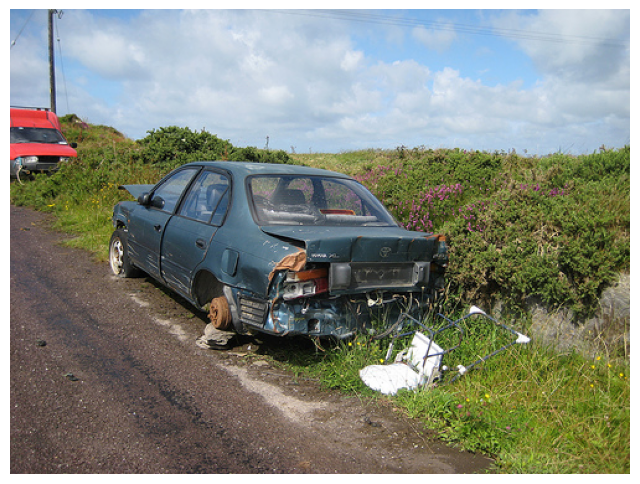

In [24]:
import matplotlib.pyplot as plt

img_path = "/kaggle/input/pascal-voc-2012-dataset/VOC2012_test/VOC2012_test/JPEGImages/2008_000029.jpg"

output = run_detection(model, img_path, conf_thresh=0.15)

plt.figure(figsize=(8,8))
plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()